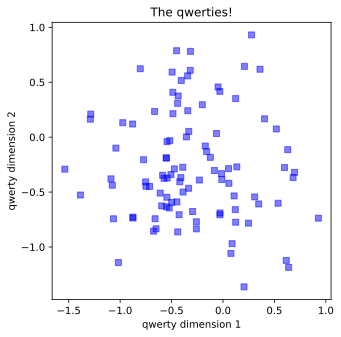

In [2]:
from ml_toolkit import createDataFunctions
createDataFunctions.createQwerties();
